# A/B-тестирование. Исследование и приоритезация гипотез для увеличения выручки интернет-магазина

Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы и проанализировать результаты A/B-теста.

Необходимо будет выполнить следующее:

- применить фреймворки `ICE` и `RICE` для приоритизации гипотез;
- проанализировать A/B-тест и построить графические зависимости для основных измеряемых и оцениваемых характеристик;
- принять решение по результатам теста и объяснить его.

### Описание данных:

В распоряжении имеются три датасета:

- **`hypothesis.csv`** содержит информацию о гипотезах;
- **`orders.csv`** содержит информацию о заказах;
- **`visitors.csv`** содержит информацию о посетителях.

Структура **`hypothesis.csv`**:

- `Hypothesis` – краткое описание гипотезы;
- `Reach` – охват пользователей по 10-балльной шкале;
- `Impact` – влияние на пользователей по 10-балльной шкале;
- `Confidence` – уверенность в гипотезе по 10-балльной шкале;
- `Efforts` – затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

Структура **`orders.csv`**:

- `transactionId` – идентификатор заказа;
- `visitorId` – идентификатор пользователя, совершившего заказ;
- `date` – дата, когда был совершен заказ;
- `revenue` – выручка заказа;
- `group` – группа A/B-теста, в которую попал заказ.

Структура **`visitors.csv`**:

- `date` – дата;
- `group` – группа A/B-теста;
- `visitors` – количество пользователей в указанную дату в указанной группе A/B-теста.

### 1. Открытие файла и изучение общей информации

---

#### 1.1 Импорт необходимых библиотек

Для начала импортируем все необходимые библиотеки для работы с данными и построением графиков.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt

#### 1.2 Изучение общей информации о датафрейме

Считаем данные из файлов и запишем их в переменные `hypothesis`, `orders` и `visitors`.

Пути к файлам:

- `/datasets/hypothesis.csv`
- `/datasets/orders.csv`
- `/datasets/visitors.csv`

In [2]:
hypothesis = pd.read_csv('datasets/hypothesis.csv')
orders = pd.read_csv('datasets/orders.csv')
visitors = pd.read_csv('datasets/visitors.csv')

Выведем первые 5 строк для каждого датасета.

In [3]:
pd.set_option('display.max_columns', None)

display(hypothesis.head(5))
display(orders.head(5))
visitors.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Выведем основную информацию о каждом датафрейме при помощи метода `info()`.

In [4]:
display(hypothesis.info())
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Заметим, что в приведенных датафреймах полностью отсутствуют пропуски. Столбцы `date` из **`orders`** и `date` из **`visitors`** имеют тип **object**. Также для более удобной работы с датафреймами в дальнейшем приведем все названия столбцов к нижнему регистру.

**Вывод:**

Первоначально изучив общую информацию об исходных датафреймах, далее можно переходить к их предобработке.

### 2. Предобработка данных

---

#### 2.1 Преобразование названий столбцов

Приведем названия всех столбцов к нижнему регистру для удобства работы с датафреймом в дальнейшем.

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

orders = orders.rename(columns={'transactionId' : 'transaction_id',
                                'visitorId' : 'visitor_id'})

Проверим, что названия всех столбцов написаны в одном, удобном стиле.

In [6]:
display(hypothesis.columns)
display(orders.columns)
visitors.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Index(['date', 'group', 'visitors'], dtype='object')

Далее можно приступить к дальнейшей предобработке датафрейма.

#### 2.2 Изменение типов данных

Преобразуем некоторые столбцы в нужные типы. Как было выяснено ранее, два столбца с датами (`date` из **`orders`**, `date` из **`visitors`**) имеют тип **object**. Преобразуем их в тип **datetime64**.

In [7]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим, что типы данных поменялись.

In [8]:
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Заметим, что типы данных для выбранных столбцов поменялись на необходимые.

#### 2.3 Обработка дубликатов

##### 2.3.1 Проверка на наличие явных дубликатов

Проверим исходные датафреймы на наличие явных строк-дубликатов.

In [9]:
display(hypothesis.duplicated().sum())
display(orders.duplicated().sum())
visitors.duplicated().sum()

0

0

0

Нетрудно заметить, что явных дубликатов в исходных выборках нет.

##### 2.3.1 Проверка на наличие неявных дубликатов

Также проверим датафреймы на наличие явных дубликатов. Рассмотрим уникальные значения столбцов с типом **object**.

Начнем с датафрейма `hypothesis`.

In [10]:
hypothesis['hypothesis'].sort_values().unique()

array(['Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию'],
      dtype=object)

Заметим, что значения в данном столбце не повторяются.

Рассмотрим датафрейм `orders`.

In [11]:
orders['group'].sort_values().unique()

array(['A', 'B'], dtype=object)

И в этом столбце также нет  повторяющихся значений.

Рассмотрим датафрейм `visitors`.

In [12]:
visitors['group'].sort_values().unique()

array(['A', 'B'], dtype=object)

Заметим, что значения в данном столбце не повторяются.

Проверка на неявные дубликаты показала, что в исходных датасетах их нет.

Дополнительно выполним проверку на попадение пользователей в обе группы.

In [13]:
orders.groupby('visitor_id').agg({'group' : 'nunique'}).query('group > 1').count()

group    58
dtype: int64

Заметим, что 58 пользователей в итоге оказались в обеих группах.

**Вывод:**

Преобразовав названия столбцов, изменив, где необходимо, тип данных, проверив датасеты на явные и неявные дубликаты, далее можно перейти к сортировке гипотез по приоритизации при помощи фреймворков `ICE` и `RICE`.

### 3. Приоритизация гипотез с помощью фреймворков ICE и RICE

---

Для того, чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, а в данном конкретном случае поспособствовать увеличению выручки, сформулированные гипотезы приоритизируют. Для этого используют различные методы. В нашем случае воспользуемся фреймворками `ICE` и `RICE`.

#### 3.1 Приоритизация гипотез при помощи метода ICE

Метод `ICE` (от англ. *impact, confidence, effort/ease*; влияние, уверенность, усилия/простота) — один из самых популярных способов приоритизации гипотез. Его значение вычисляется по формуле:

$$ICE = Impact \cdot Confidence \cdot Ease,$$

или

$$ICE = \dfrac {Impact \cdot Confidence}{Efforts}.$$

Посчитаем параметр `ICE`, используя датафрейм **`hypothesis`**, и выведем гипотезы в порядке убывания по данному показателю.

In [14]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)

pd.set_option('max_colwidth', 200)

hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Заметим, что наиболее перспективными явлюятся гипотезы под номерами **8**, **0**, **7**, **6** и **2**.

#### 3.2 Приоритизация гипотез при помощи метода RICE

Метод `RICE` является модификаицей метода `ICE` с добавлением параметра *R* (от англ. *reach*, охват). Соотвественно формула имеет следующий вид:

$$RICE = \dfrac {Reach \cdot Impact \cdot Confidence}{Efforts}.$$

Посчитаем параметр `RICE`, используя датафрейм **`hypothesis`**, и выведем гипотезы в порядке убывания по данному показателю.

In [15]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

pd.set_option('max_colwidth', 200)

hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По расчетам метода `RICE` наиболее перспективными являются гипотезы под номерами **7**, **2**, **0** и **6**.

**Вывод:**

Таким образом, при использовании методов приоритизации гипотез `ICE` и `RICE` были отобраны наиболее перспективные гипотезы. Однако результаты для двух методов отличаются. Данное отличие возникает по причине использования дополнительного параметра **Reach**, который отражает охват пользователей. С его учетом наиболее перспективными окажутся гипотезы под номерами **7**, **0** и **6** со следующими формулировками:

- `Гипотеза №7`: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
- `Гипотеза №0`: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
- `Гипотеза №6`: Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Далее протестируем одну из гипотез, а именно под номером **0**.

### 4. Анализ A/B-теста. Построение графических зависимостей для основных и измеряемых метрик

---

После проведения A/B-теста гипотезы под номером **0** были получены результаты, которые приведены в датафреймах `orders` и `visitors`. Проанализируем полученные результаты и построим интересующие графические зависимости.

In [16]:
display(orders.head())
visitors.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


#### 4.1 Анализ кумулятивных метрик

Изучим графики кумулятивных, или накапливаемых данных. Таким образом получится отследить изменения результатов эксперимента за каждый день тестирования. Также по центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего, после этого зачастую можно определить, стоит останавливать тест или нет.

Построим графики кумулятивной выручки, кумулятивного среднего чека, относительного изменения кумулятивного среднего чека группы B к группе A, кумулятивного среднего количества заказов на посетителя по группам, относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

Чтобы построить графики, нужно собрать кумулятивные данные. Для этого необходимо будет создать новый датафрейм **`cumulative_data`**. Однако для начала создадим массив уникальных пар значений дат и групп теста.

In [17]:
# создание массива уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# получение агрегированных кумулятивных данных по дням о заказах
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transaction_id' : 'nunique',
            'visitor_id' : 'nunique',
            'revenue' : 'sum'
        }
    ), axis=1).sort_values(by=['date', 'group'])
                                                        
# получение агрегированных кумулятивных данных по дням о посетителях
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'visitors' : 'sum'
        }
    ), axis=1).sort_values(by=['date', 'group'])

# объединение кумулятивных данных в одну таблицу
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
                                                            
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


##### 4.1.1 Анализ кумулятивной выручки по дням и группам

Теперь можно построить график кумулятивной выручки по дням и группам A/B-тестирования.

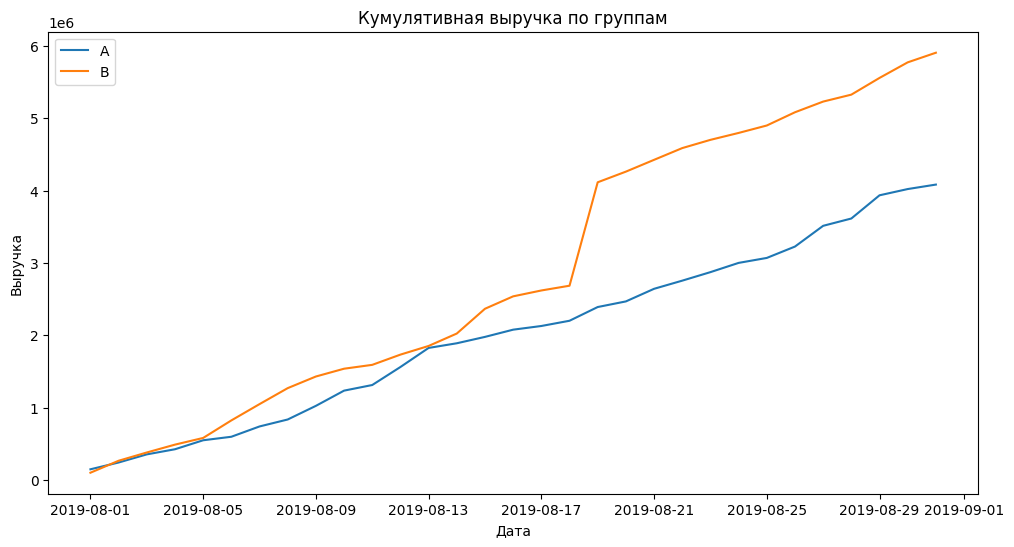

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе A
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе A
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по группам')

# график выручки группы A
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.legend();

По графику видно, что выручка почти равномерно увеличивается в течение всего теста, однако для группы **B** наблюдается резкий всплеск с 18 по 19 августа. Это может сигнализировать о всплеске числа заказов или о появлении очень дорогих заказов в выборке.

##### 4.1.2 Анализ кумулятивного среднего чека по группам

Построим график среднего чека по группам - разделим кумулятивную выручку на кумулятивное число заказов.

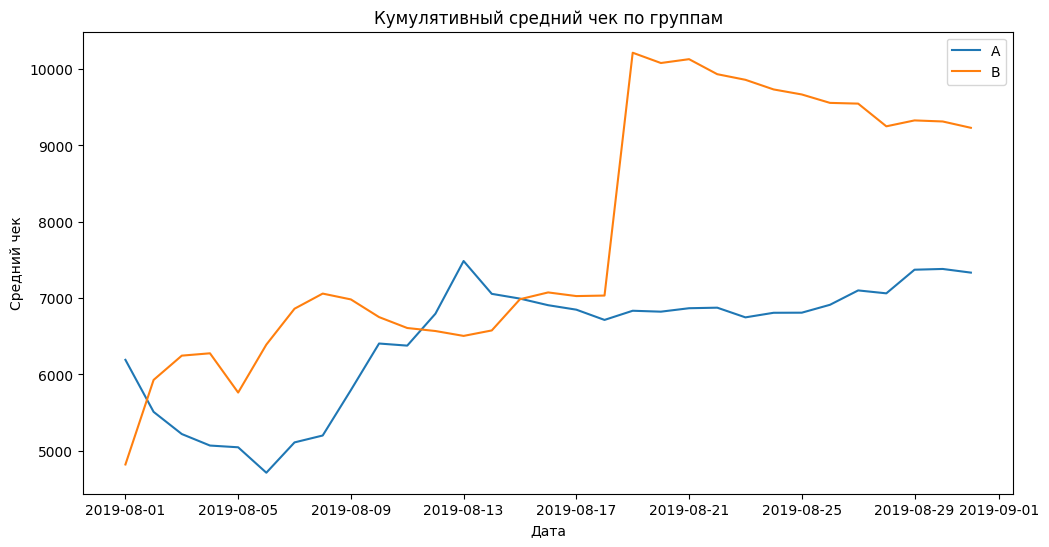

In [19]:
plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Кумулятивный средний чек по группам')

# график среднего чека группы A
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')

# график среднего чека группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.legend();

Также для группы **B** наблюдается всплеск с 18 по 19 августа, но ближе к концу теста значение для данной группы начинает уменьшаться. Возможно, в этот период могли попасть крупные заказы, которые и отразились скачком на графике. Таким образом, необходим больший объем данных для того, чтобы прийти к реальному значению среднего чека и установиться на его уровне.

##### 4.1.3 Анализ относительного изменения кумулятивного среднего чека группы B к группе A

Далее построим график относительного различия для среднего чека.

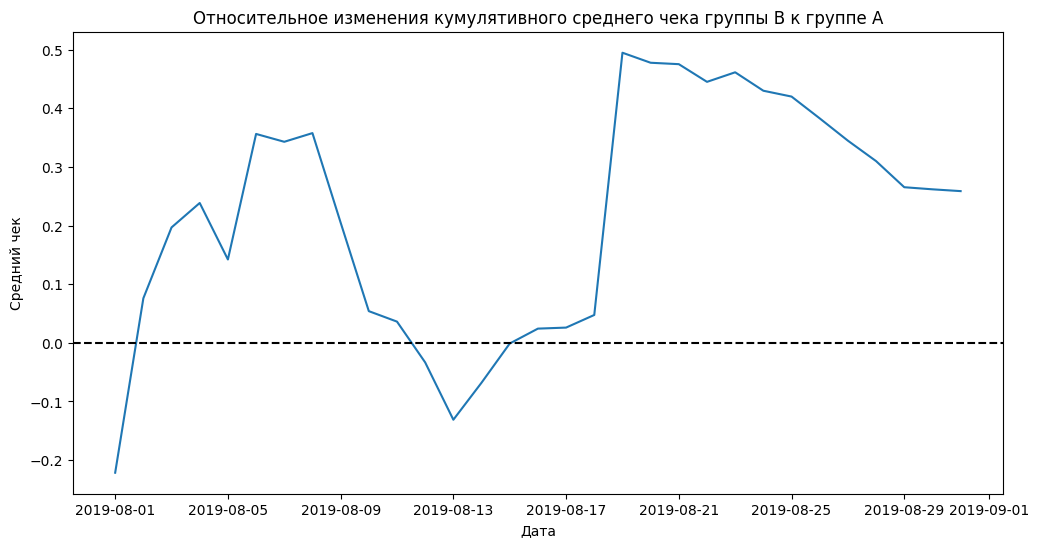

In [20]:
# сбор данных в один датафрейм
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b,
                                                       left_on='date',
                                                       right_on='date',
                                                       how='left',
                                                       suffixes=['_a', '_b'])

plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Относительное изменения кумулятивного среднего чека группы B к группе A')

# построение отношения средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a']) - 1)

# добавление оси X
plt.axhline(y=0, color='black', linestyle='--');

В нескольких участках графика различия между сегментами наблюдаются выбросы, так что вполне вероятно, что это может быть обусловлено крупными заказами.

##### 4.1.4 Анализ кумулятивного среднего количества заказов на посетителя по группам

Аналогично проанализируем график кумулятивного среднего количества заказов на посетителя по группам.

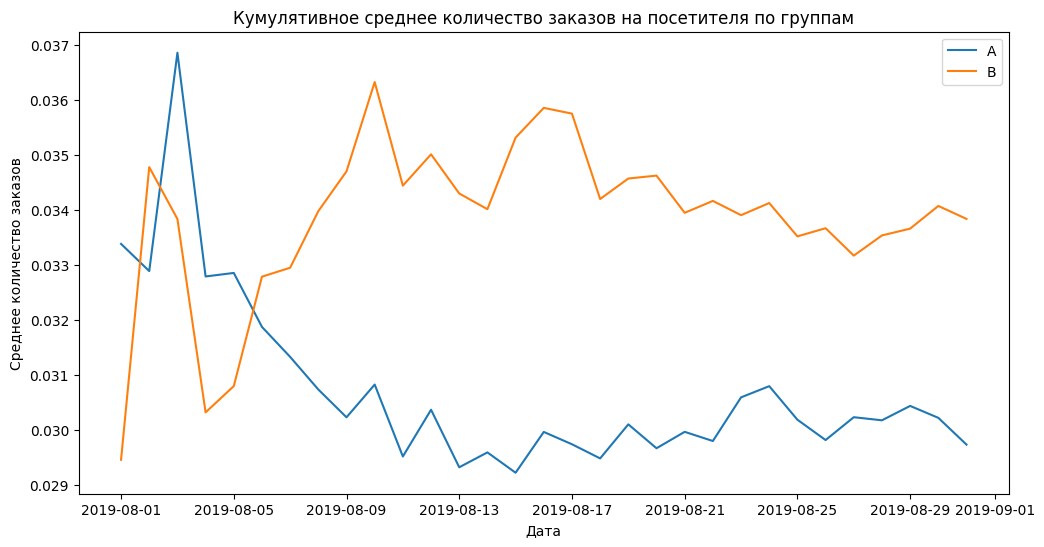

In [21]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# отделение данных по группе А
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']

# отделение данных по группе B
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

# построение графиков
plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend();

Видно, что показатель среднего количества заказов для группы **B** резко вырвался вперед в начале теста и начал потихоньку стабилизироваться около одного значения, в то время как для группы **A** он оказался значительно ниже, и также после резкого скачка в самом начале начал колебаться вокруг определенного значения.

##### 4.1.5 Анализ относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

Построим график относительного различия кумулятивного среднего количества заказов на посетителя группы B к группе A.

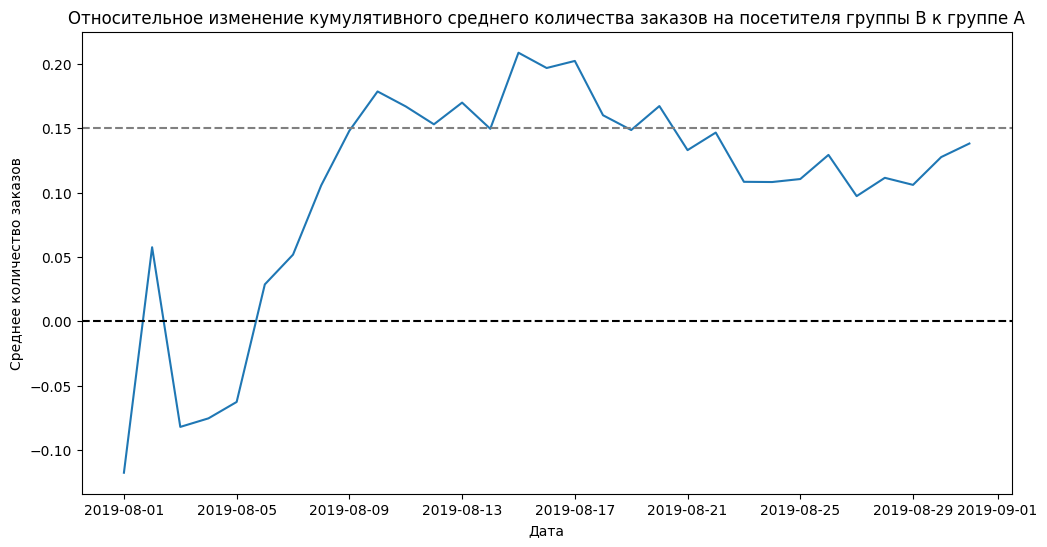

In [22]:
# сбор данных в один датафрейм
merged_cumulative_conversions = cumulative_data_a[['date', 'conversion']].merge(cumulative_data_b[['date', 'conversion']],
                                                                                left_on='date',
                                                                                right_on='date',
                                                                                how='left',
                                                                                suffixes=['_a', '_b'])

plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')

# построение отношения среднего количества заказов
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a'] - 1)

# добавление горизонтальных линий
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--');

По графику видно, что группа **B** с течением времени начала выигрывать по данному показателю у группы **A**. Однако показатель относительного различия среднего количества заказов для двух групп еще полностью не установился, наблюдается лишь тенденция к стабилизации около уровня 0,15. Необходимо дополнительно проанализировать количество заказов, оформляемых посетителями.

#### 4.2 Анализ по оформляемым заказам

##### 4.2.1 Построение точечного графика количества заказов по пользователям

Оценим количество заказов по пользователям и построим точечный график.

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


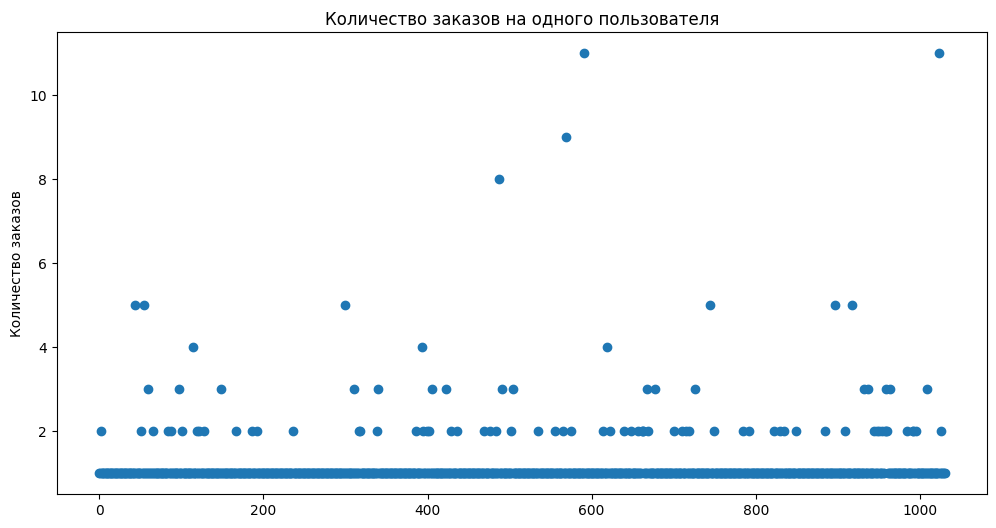

In [23]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(12, 6))
plt.ylabel('Количество заказов')
plt.title('Количество заказов на одного пользователя')
plt.scatter(x_values, orders_by_users['orders']);

По графику видно, что большинство пользователей оформляли не более 1 заказа, однако нетрудно заметить несколько выбросов с большим количеством заказов. Дополнительно посчитаем 95-й и 99-й перцентили для оценки количества заказов на одного пользователя.

In [24]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше чем 1 заказ и не более 1% больше чем 2. Выберем 1 заказ на одного пользователя в качестве верхней границы числа заказов и тем самым отсеем аномальных пользователей по этому показателю.

In [25]:
orders_border = np.percentile(orders_by_users['orders'], 95)

#### 4.3 Анализ по стоимости заказов

Оценим стоимость заказов для каждого пользователя и построим точечный график. Таким образом выберем верхнюю границу для определения аномальных заказов и отсеем заказы со слишком  высокой стоимостью.

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
858        192721366  1316129916 2019-08-27    93940     A
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
682       1216533772  4266935830 2019-08-29    78990     B
662       1811671147  4266935830 2019-08-29    78990     A
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A


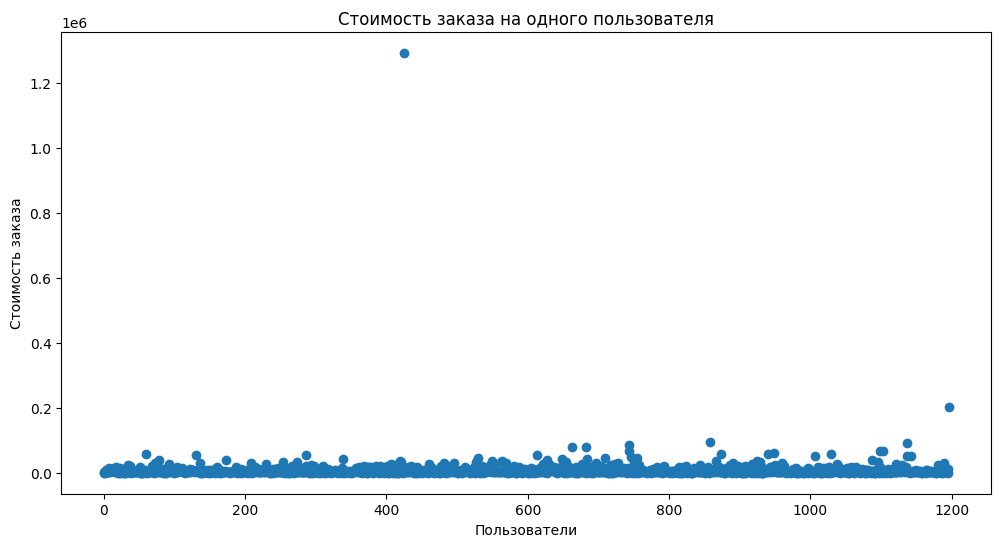

In [26]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в orders
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(12, 6))
plt.ylabel('Стоимость заказа')
plt.xlabel('Пользователи')
plt.title('Стоимость заказа на одного пользователя')
plt.scatter(x_values, orders['revenue']);

Дополнительно построим этот же график, но с изменным масштабом для оси Y.

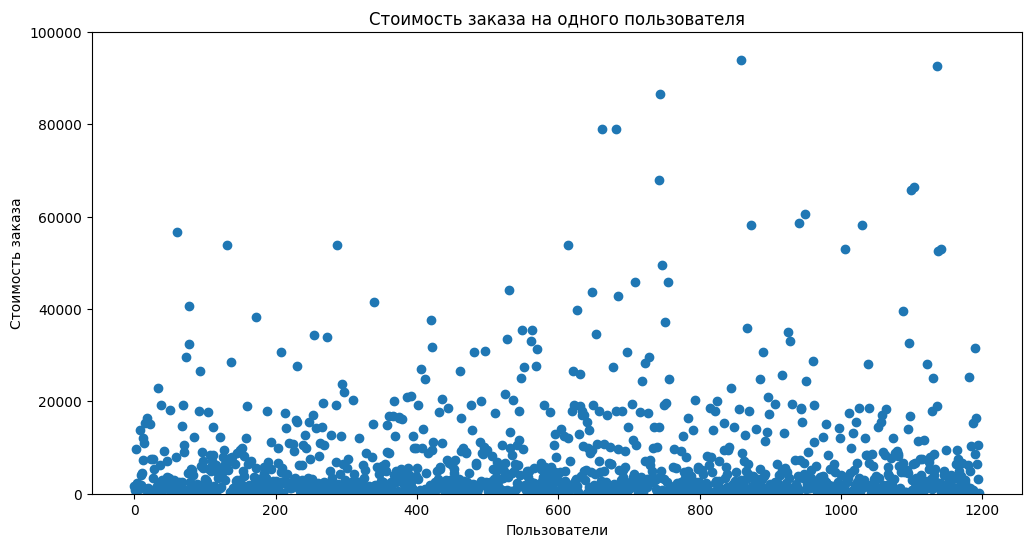

In [27]:
plt.figure(figsize=(12, 6))
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.ylim([0, 0.1e6])
plt.title('Стоимость заказа на одного пользователя')
plt.scatter(x_values, orders['revenue']);

Для большинства заказов их стоимость не превышает 30 000, однако также можно заметить некоторые аномальные выбросы. Посчитаем 95-й и 99-й перцентили для дополнительной оценки верхней границы.

In [28]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже чем 26 785 заказа и не более 1% дороже чем 53 904. Выберем стоимость заказа равную 26 785 в качестве верхней границы и тем самым отсеем аномальных пользователей по этому показателю.

In [29]:
revenue_border = np.percentile(orders['revenue'], 95)

#### 4.4 Расчет статистической значимости и ее оценка

##### 4.4.1 Статистическая значимость различий в среднем количестве заказов на посетителя по "сырым" данным

Посчитаем статистическую значимость различий в среднем количестве заказов на пользователя и среднем чеке заказа между группами по "сырым" данным - без удаления аномальных пользователей.

Сформулируем гипотезы:

- **Нулевая**: *Статистически значимых различий в среднем количестве заказов между группами по имеющимся данным нет*.
- **Альтернативная**: *Статистически значимые различия в среднем количестве заказов между группами по имеющимся данным есть*.

Установим уровень статистической значимости:
$$\alpha = 0,05.$$

Поскольку в исходных данных имеются выбросы и распределение для них не имеет вид нормального, будем использовать критерий, основанный на структурированном или непараметрическом подходе, а именно **"U-критерий Манна-Уитни"**.

Произведем необходимую подготовку данных и посчитаем статистическую значимость.

In [30]:
# подготовка данных

visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# количество пользователей в выбранную дату в группе A
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# количество пользователей в выбранную дату в группе B
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# суммарное количество заказов до выбранной даты включительно в группе A
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# суммарное количество заказов до выбранной даты включительно в группе B
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

# пользователи группы A, которые оформили хотя бы один заказ
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

# пользователи группы B, которые оформили хотя бы один заказ
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

# количество заказов для пользователей группы A
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# количество заказов для пользователей группы B
sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Относительный выигрыш/проигрыш группы B: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.017
Относительный выигрыш/проигрыш группы B: 0.138


Получили, что по "сырым" данным имеются различия в среднем количестве заказов между группами **A** и **B**, поскольку рассчитанное **p-value** (0,011) сильно меньше заданной границы (0,05). При этом относительный выигрыш группы **B** равен 16%. Таким образом, нулевую гипотезу можно отвергнуть.

##### 4.4.2 Статистическая значимость различий в среднем чеке заказа между группами по "сырым" данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "сырым" данным - без удаления аномальных пользователей.

Сформулируем гипотезы:

- **Нулевая**: *Статистически значимых различий в среднем чеке между группами по имеющимся данным нет*.
- **Альтернативная**: *Статистически значимые различия в среднем чеке между группами по имеющимся данным есть*.

Установим уровень статистической значимости:
$$\alpha = 0,05.$$

Поскольку в исходных данных имеются выбросы и распределение для них не имеет вид нормального, будем использовать критерий, основанный на структурированном или непараметрическом подходе, а именно **"U-критерий Манна-Уитни"**.

Посчитаем статистическую значимость.

In [31]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный выигрыш/проигрыш группы B: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Относительный выигрыш/проигрыш группы B: 0.259


Таким образом, рассчитанный **p-value** значительно больше 0,05, поэтому причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы **B** выше на 28,7% среднего чека группы **A**.

##### 4.4.3 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по "очищенным" данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по "очищенным" данным - с удалением аномальных пользователей.

Сформулируем гипотезы:

- **Нулевая**: *Статистически значимых различий в среднем количестве заказов между группами по очищенным от выбросов данных нет*.
- **Альтернативная**: *Статистически значимые различия в среднем количестве заказов между группами по очищенным от выбросов данных есть*.

Установим уровень статистической значимости:
$$\alpha = 0,05.$$

Поскольку в исходных данных имеются выбросы и распределение для них не имеет вид нормального, будем использовать критерий, основанный на структурированном или непараметрическом подходе, а именно **"U-критерий Манна-Уитни"**.

In [32]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > orders_border]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > orders_border]['visitor_id']
    ],
    axis=0,
)

users_with_expensive_orders = orders[orders['revenue'] > revenue_border]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# количество заказов для пользователей группы A
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# количество заказов для пользователей группы B
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный выигрыш/проигрыш группы B: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

P-value: 0.013
Относительный выигрыш/проигрыш группы B: 0.173


Заметим, что рассчитанный **p-value** оказался ниже заданного значения (0,05). Значит нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Выигрыш группы **B** составил 17,4%.

##### 4.4.4 Статистическая значимость различий в среднем чеке заказа между группами по "очищенным" данным

Посчитаем статистическую значимость различий в среднем чеке между группами по "очищенным" данным - с удалением аномальных пользователей.

Сформулируем гипотезы:

- **Нулевая**: *Статистически значимых различий в среднем чеке между группами по очищенным от выбросов данных нет*.
- **Альтернативная**: *Статистически значимые различия в среднем чеке между группами по очищенным от выбросов данных есть*.

Установим уровень статистической значимости:
$$\alpha = 0,05.$$

Поскольку в исходных данных имеются выбросы и распределение для них не имеет вид нормального, будем использовать критерий, основанный на структурированном или непараметрическом подходе, а именно **"U-критерий Манна-Уитни"**.

In [33]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный выигрыш/проигрыш группы B: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.738
Относительный выигрыш/проигрыш группы B: -0.020


Рассчитанное p-value (0,72) больше заданной границы (0,05), значит нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем. Относительный проигрыш группы **B** равен 3,4%.

По проведенному анализу можно сделать следующие **выводы**:

- Нет статистически значимого различия по среднему количеству заказов между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом выигрыш группы **B** в среднем составляет 16,5%.

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Однако фильтрация оказала сильное влияние на данные по сравнению двух групп сильно: вместо выигрыша в 28,7% группа **B** по итогу проигрывает группе **A** на 3,4%.

- График различия среднего чека между группами сообщает, что результаты группы **B** лучше группы **A**. В некоторых участках на графике наблюдаются выбросы, однако это может быть обусловлено крупными заказами в эти даты.

- График различия среднего количества заказов между группами сообщает, что с течением времени проведения теста результаты группы **B** стали лучше группы **A**. Однако показатель относительного различия среднего количества заказов для двух групп еще полностью не установился, наблюдается лишь тенденция к стабилизации около уровня 0,15.

### 5. Общий вывод

---

В данной работе были проанализированы данные о заказах, посетителях и списке гипотез, которые необходимо было приоритизировать при помощи фреймворков `ICE` и `RICE`. После приоритизации гипотез были выбраны самые перспективные из них для проведения теста и в перспективе увеличения выручки интернет-магазина. На этапе предобработки данных были преобразованы названия столбцов, проверено наличие пропусков в данных, изменены типы данных там, где это было необходимо, проверено наличие явных и неявных дубликатов. Были проанализированы результаты A/B-теста, из которых было выявлено следующее:

- Нет статистически значимого различия по среднему количеству заказов между группами ни по «сырым», ни по данным после фильтрации аномалий. При этом выигрыш группы B в среднем составляет 16,5%.

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Однако фильтрация оказала сильное влияние на данные по сравнению двух групп сильно: вместо выигрыша в 28,7% группа B по итогу проигрывает группе A на 3,4%.

- График различия среднего чека между группами сообщает, что результаты группы B лучше группы A. В некоторых участках на графике наблюдаются выбросы, однако это может быть обусловлено крупными заказами в эти даты.

- График различия среднего количества заказов между группами сообщает, что с течением времени проведения теста результаты группы B стали лучше группы A. Однако показатель относительного различия среднего количества заказов для двух групп еще полностью не установился, наблюдается лишь тенденция к стабилизации около уровня 0,15.

Таким образом, на основании результатов, полученных после анализа A/B-теста, можно сделать вывод, что по совокупности показателей группа B выигрывает в данном тесте. Значения среднего чека по двум группам приблизительно равны, однако по среднему количеству заказов явно лидирует группа B. Поэтому рекомендуется остановить A/B-тест и засчитать победу группы B.